# Face Mask Detector

In [1]:
# Import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception, VGG16, InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import random

In [2]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
labels = ['with_mask', 'without_mask']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    random.shuffle(data)
    return np.array(data)

In [3]:
train = get_training_data('C:/Users/ASUS/Face_mask_Detection/train')
test = get_training_data('C:/Users/ASUS/Face_mask_Detection/test')
val = get_training_data('C:/Users/ASUS/Face_mask_Detection/validation')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6660\2723724417.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


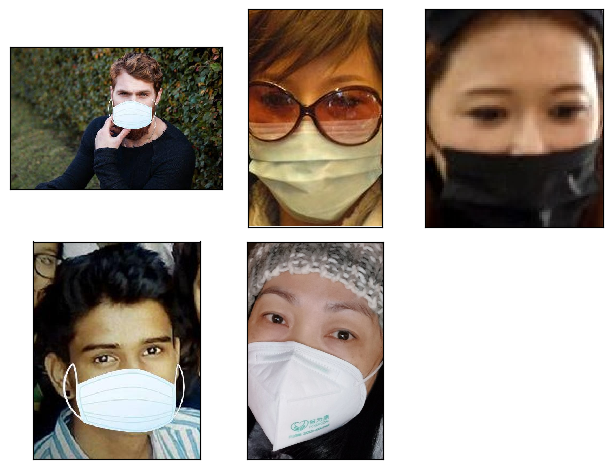

In [45]:
img_size = 224 
path = os.path.join('C:/Users/ASUS/Face_mask_Detection/train', 'with_mask')
i=0
for img in os.listdir(path)[:5]:
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    img_arr = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB), interpolation='none')
    plt.tight_layout()
    i=i+1;

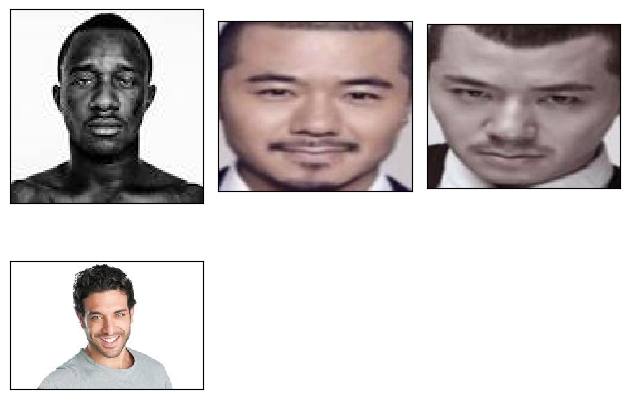

In [48]:
img_size = 224 
path = os.path.join('C:/Users/ASUS/Face_mask_Detection/train', 'without_mask')
i=0
for img in os.listdir(path)[:4]:
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    img_arr = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB), interpolation='none')
    plt.tight_layout()
    i=i+1;

In [4]:
# convert the data and labels to NumPy arrays
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [60]:
print("Number images in training set:",len(x_train))
print("Number images in training set:",len(x_val))
print("Number images in training set:",len(x_test))

Number images in training set: 2000
Number images in training set: 500
Number images in training set: 500


In [61]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [62]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [52]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

## Prepare network architectures

In [44]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off

def MobileNetV2_model():
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    
    # loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
    for layer in baseModel.layers[:-4]:
        layer.trainable = False
        
    # construct the head of the model that will be placed on top of the the base model

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # compile our model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer=opt)
    return model

In [45]:
# load the Xception network, ensuring the head FC layer sets are left off

def Xception_model():
    baseModel = Xception(include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    # loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    
    # construct the head of the model that will be placed on top of the the base model

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # compile our model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
    return model

In [46]:
# load the VGG16 network, ensuring the head FC layer sets are left off

def VGG16_model():
    baseModel = VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    
    # loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False

    # construct the head of the model that will be placed on top of the the base model

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # compile our model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer=opt)
    return model

## Data Augmentation

In [63]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [48]:
Model_Mobilenet = MobileNetV2_model()

In [49]:
Model_Xception = Xception_model()

83683744/83683744 [==============================] - 11s 0us/step


In [50]:
Model_Vgg = VGG16_model()

58889256/58889256 [==============================] - 7s 0us/step


## Xception Network Architecture

In [64]:
# train the head of the network
History_Xception = Model_Xception.fit(datagen.flow(x_train,y_train, batch_size = BS) ,
                                      epochs = EPOCHS ,
                                      validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 121s 2s/step - loss: 0.1806 - accuracy: 0.9350 - val_loss: 0.1000 - val_accuracy: 0.9660
Epoch 2/10
63/63 [==============================] - 136s 2s/step - loss: 0.0788 - accuracy: 0.9750 - val_loss: 0.0689 - val_accuracy: 0.9760
Epoch 3/10
63/63 [==============================] - 135s 2s/step - loss: 0.0668 - accuracy: 0.9795 - val_loss: 0.0631 - val_accuracy: 0.9800
Epoch 4/10
63/63 [==============================] - 125s 2s/step - loss: 0.0602 - accuracy: 0.9790 - val_loss: 0.0593 - val_accuracy: 0.9840
Epoch 5/10
63/63 [==============================] - 129s 2s/step - loss: 0.0434 - accuracy: 0.9870 - val_loss: 0.0785 - val_accuracy: 0.9820
Epoch 6/10
63/63 [==============================] - 127s 2s/step - loss: 0.0511 - accuracy: 0.9785 - val_loss: 0.0542 - val_accuracy: 0.9840
Epoch 7/10
63/63 [==============================] - 126s 2s/step - loss: 0.0396 - accuracy: 0.9845 - val_loss: 0.0545 - val_accuracy: 0.9780
Epoch 8/10
63

In [65]:
# serialize the model to disk
Model_Xception.save("Model_Xception.h5")

In [67]:
## show model accuracy and loss with test set
print("Loss of the model is - " , Model_Xception.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , Model_Xception.evaluate(x_test,y_test)[1]*100 , "%")

16/16 [==============================] - 33s 2s/step - loss: 0.0439 - accuracy: 0.9900
Loss of the model is -  0.04390333220362663
16/16 [==============================] - 32s 2s/step - loss: 0.0439 - accuracy: 0.9900
Accuracy of the model is -  99.00000095367432 %


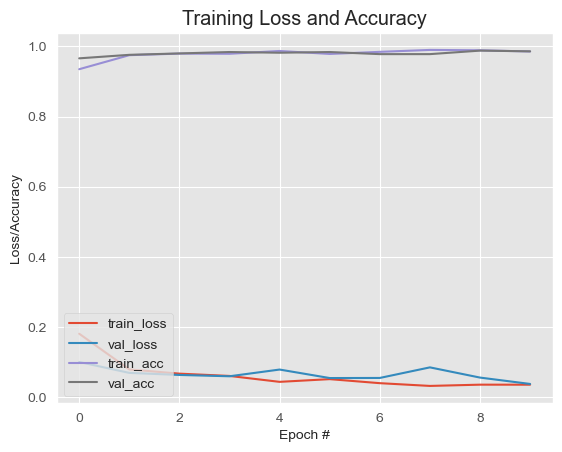

In [94]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History_Xception.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History_Xception.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History_Xception.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History_Xception.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation_xception.png')

In [74]:
# make predictions on the testing set
predictions = (Model_Xception.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

16/16 [==============================] - 37s 2s/step


array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [76]:
# show a nicely formatted classification report
print(classification_report(y_test, predictions, target_names = ['with_mask (Class 0)','Without_mask (Class 1)']))

                        precision    recall  f1-score   support

   with_mask (Class 0)       0.99      0.99      0.99       250
Without_mask (Class 1)       0.99      0.99      0.99       250

              accuracy                           0.99       500
             macro avg       0.99      0.99      0.99       500
          weighted avg       0.99      0.99      0.99       500



In [79]:
## show confusion matrix
cm = confusion_matrix(y_test,predictions)
cm

array([[248,   2],
       [  3, 247]], dtype=int64)

In [82]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

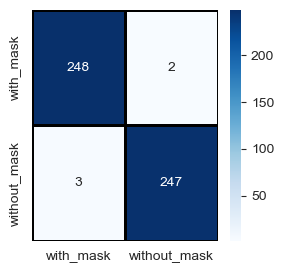

In [85]:
plt.figure(figsize = (3,3))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [86]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3852\1517252546.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


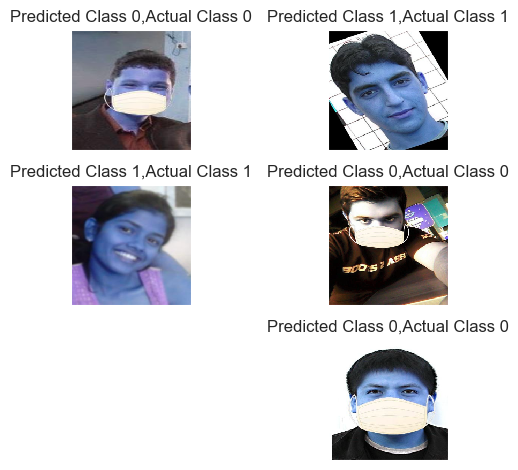

In [89]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224,224,3), interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

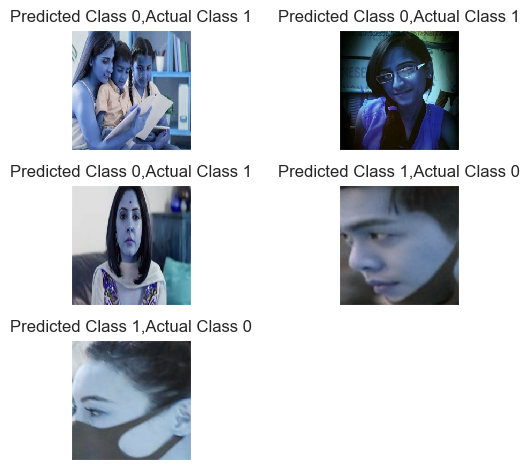

In [92]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(224,224,3), interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## MobileNetV2 Network Architecture

In [93]:
History_Mobilenet = Model_Mobilenet.fit(datagen.flow(x_train,y_train, batch_size = BS) ,
                                      epochs = EPOCHS ,
                                      validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 74s 1s/step - loss: 0.3438 - accuracy: 0.8625 - val_loss: 0.1528 - val_accuracy: 0.9380
Epoch 2/10
63/63 [==============================] - 67s 1s/step - loss: 0.1247 - accuracy: 0.9515 - val_loss: 0.1575 - val_accuracy: 0.9480
Epoch 3/10
63/63 [==============================] - 67s 1s/step - loss: 0.0969 - accuracy: 0.9680 - val_loss: 0.0989 - val_accuracy: 0.9640
Epoch 4/10
63/63 [==============================] - 68s 1s/step - loss: 0.0744 - accuracy: 0.9735 - val_loss: 0.1201 - val_accuracy: 0.9600
Epoch 5/10
63/63 [==============================] - 66s 1s/step - loss: 0.0640 - accuracy: 0.9770 - val_loss: 0.1029 - val_accuracy: 0.9680
Epoch 6/10
63/63 [==============================] - 68s 1s/step - loss: 0.0501 - accuracy: 0.9810 - val_loss: 0.1251 - val_accuracy: 0.9600
Epoch 7/10
63/63 [==============================] - 69s 1s/step - loss: 0.0729 - accuracy: 0.9780 - val_loss: 0.1082 - val_accuracy: 0.9640
Epoch 8/10
63/63 [==

In [97]:
Model_Mobilenet.save("Model_Mobilenet.h5")

In [95]:
## show model accuracy and loss with test set
print("Loss of the model is - " , Model_Mobilenet.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , Model_Mobilenet.evaluate(x_test,y_test)[1]*100 , "%")

16/16 [==============================] - 7s 398ms/step - loss: 0.0208 - accuracy: 0.9980
Loss of the model is -  0.0208375696092844
16/16 [==============================] - 6s 377ms/step - loss: 0.0208 - accuracy: 0.9980
Accuracy of the model is -  99.80000257492065 %


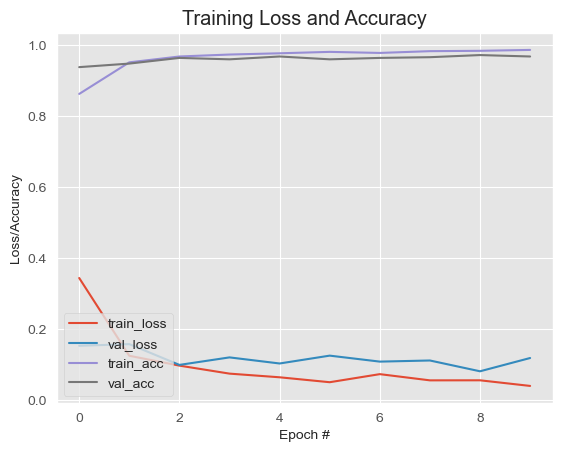

In [96]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History_Mobilenet.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History_Mobilenet.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History_Mobilenet.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History_Mobilenet.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation_mobilenet.png')

## VGG16 Network Architecture

In [98]:
History_Vgg = Model_Vgg.fit(datagen.flow(x_train,y_train, batch_size = BS) ,
                                      epochs = EPOCHS , 
                                      validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 348s 5s/step - loss: 0.5558 - accuracy: 0.7050 - val_loss: 0.3464 - val_accuracy: 0.8740
Epoch 2/10
63/63 [==============================] - 336s 5s/step - loss: 0.2988 - accuracy: 0.8850 - val_loss: 0.2243 - val_accuracy: 0.9180
Epoch 3/10
63/63 [==============================] - 336s 5s/step - loss: 0.2061 - accuracy: 0.9215 - val_loss: 0.2500 - val_accuracy: 0.8940
Epoch 4/10
63/63 [==============================] - 333s 5s/step - loss: 0.2020 - accuracy: 0.9265 - val_loss: 0.1568 - val_accuracy: 0.9440
Epoch 5/10
63/63 [==============================] - 333s 5s/step - loss: 0.1583 - accuracy: 0.9430 - val_loss: 0.1853 - val_accuracy: 0.9160
Epoch 6/10
63/63 [==============================] - 332s 5s/step - loss: 0.1519 - accuracy: 0.9485 - val_loss: 0.1669 - val_accuracy: 0.9320
Epoch 7/10
63/63 [==============================] - 331s 5s/step - loss: 0.1186 - accuracy: 0.9580 - val_loss: 0.1378 - val_accuracy: 0.9420
Epoch 8/10
63

In [99]:
Model_Vgg.save("Model_Vgg.h5")

In [100]:
## show model accuracy and loss with test set
print("Loss of the model is - " , Model_Vgg.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , Model_Vgg.evaluate(x_test,y_test)[1]*100 , "%")

16/16 [==============================] - 65s 4s/step - loss: 0.1167 - accuracy: 0.9460
Loss of the model is -  0.11666497588157654
16/16 [==============================] - 65s 4s/step - loss: 0.1167 - accuracy: 0.9460
Accuracy of the model is -  94.59999799728394 %


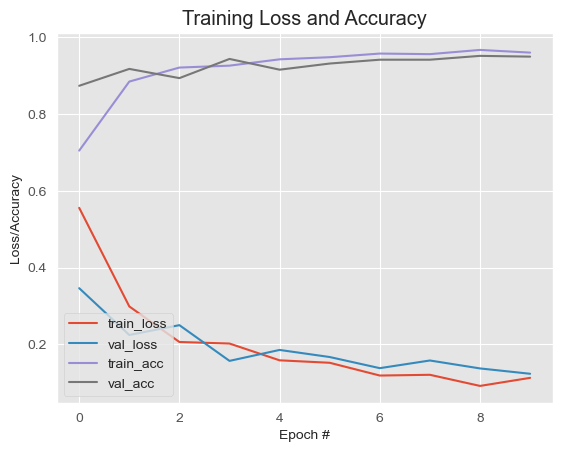

In [101]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History_Vgg.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History_Vgg.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History_Vgg.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History_Vgg.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation_vgg.png')

## Real time face mask detection

In [2]:
model=load_model('Model_Vgg.h5')

In [ ]:
path = "haarcascade_frontalface_default.xml"
font_scale = 1
font = cv2.FONT_HERSHEY_SIMPLEX

rectangle_bgr = (255,255,255)
img = np.zeros((500,500))
text = "some text in the box"
(text_width,text_height) = cv2.getTextSize(text, font , fontScale = font_scale, thickness = 1)[0]
#set the text start position
text_offset_x = 10
text_offset_y = img.shape[0]-25
#make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x,text_offset_y),(text_offset_x+text_width+2, text_offset_y - text_height-2))
cv2.rectangle(img,box_coords[0],box_coords[1],rectangle_bgr,cv2.FILLED)
cv2.putText(img, text, (text_offset_x,text_offset_y),font, fontScale = font_scale, color = (0,0,0), thickness=1)

cap = cv2.VideoCapture(1)
#check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open webcam")

while True:
    ret,frame = cap.read()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame,(x,y), (x+w, y+h),(255,0,0),2)
        facess = face_cascade.detectMultiScale(roi_gray)
        
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]
    final_image = cv2.resize(face_roi,(224,224))
    final_image = np.expand_dims(final_image,axis=0)## need fourth dimension
    final_image = final_image/255.0
    font = cv2.FONT_HERSHEY_SIMPLEX
    Predictions = model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if(Predictions>0.5):
        status = "No Mask"
        x1,y1,w1,h1 = 0,0,175,175
        # Draw black background rectangle
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status, (x1+int(w1/10),y1+int(h1/2)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255))
    else:
        status = "Face Mask"
        x1,y1,w1,h1 = 0,0,175,175
        # Draw black background rectangle
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status, (x1+int(w1/10),y1+int(h1/2)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)
        cv2.putText(frame,status,(100,150),font,3,(0,255,0),2,cv2.LINE_4)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0))
        
    cv2.imshow("LIVE FACE MASK DETECTION",frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
  
    
                
        

1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 345ms/step
